# Evaluation



In [1]:
import os
import sys
from pathlib import Path

proj_root = Path(os.getcwd()).parent
if str(proj_root) not in sys.path:
    sys.path.append(str(proj_root))

## Model setup

File `../snapshots/20cr/ckpt/1000000.pth` is the model checkpoint obtained by Kadow et al., trained by 500,000 iterations of full optimization, and another 500,000 iterations of fune-tuning.

In [2]:
import torch
from net import PConvUNet
from util.io import load_ckpt

model = PConvUNet()
#load_ckpt('../snapshots-reproduced/20cr/ckpt/500000.pth', [('model', model)])
# load_ckpt('../snapshots-reproduced/20cr/ckpt/750000.pth', [('model', model)])
load_ckpt('../snapshots-ft-reproduced/20cr/ckpt/1000000.pth', [('model', model)])
#load_ckpt('../snapshots/20cr/ckpt/1000000.pth', [('model', model)])
model.eval()

## Some auxiliary functions

In [3]:
%config InlineBackend.figure_format = 'retina'
import copy
from pathlib import Path
import h5py
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs

   
def draw_datapoint(data, x='lon', y='lat', proj='pc', index=None, clip=None,
                 central_longitude=None, central_latitude=None):
    projections = {
        'pc': ccrs.PlateCarree,
        'aea': ccrs.AlbersEqualArea,
        'ae': ccrs.AzimuthalEquidistant,
        'm': ccrs.Mollweide,
        'r': ccrs.Robinson,
        's': ccrs.Stereographic,
        'e1': ccrs.EckertI,
        'e2': ccrs.EckertII,
        'e3': ccrs.EckertIII,
        'e4': ccrs.EckertIV,
        'ee': ccrs.EqualEarth,
    }
    data = data.clip(-clip, clip) if clip is not None else data
    proj_func = projections[proj]
    proj_kwargs = {}
    if central_longitude is not None:
        proj_kwargs = {**proj_kwargs, 'central_longitude': central_longitude}
    if central_latitude is not None:
        proj_kwargs = {**proj_kwargs, 'central_latitude': central_latitude}
    
    fig = plt.figure(figsize=(9, 3))
    ax = plt.axes(projection=proj_func(**proj_kwargs))
    ax.set_global()
    ax.coastlines()
    data.plot.pcolormesh(ax=ax, x=x, y=y, transform=ccrs.PlateCarree())
    
def draw_dataset(file_name=None, dataset=None, var='TMP', index=None,
                 **kwargs ):
    dset_ = xr.open_dataset(file_name) if dataset is None else dataset
    print(f'Length: {len(dset_)}')
    print(dset_.data_vars)
    index = 1 if index is None else index
    data = dset_[var][index]
    draw_datapoint(data, **kwargs)
 

## Datasets

### HadCRUT4

In [4]:
dset_hc4 = xr.open_dataset('../dataset/HadCRUT/HadCRUT.4.6.0.0.median.nc')

### 20CR

It is the 56th member loaded in the paper, and this is supposed to be in the version 2 of the 20CR dataset.
However, I cannot find a detailed description of the ensemble members, and thus it is unable to locate the same member in the version 3 (20CRv3).
Here, the 80th member of 20CRv3 is used to recover Fig 1.

In [5]:
dset_20cr80 = xr.open_dataset('../dataset/data_large/20cr/20cr-mem080.h5')

## Sanity check: using the random-walk mask just as training

In [6]:
def reconstruct_rwmasked(length=1):
    from generate_data import random_walk_batch
    mask = random_walk_batch(np.ones((1, 72, 72), dtype=np.int), 72*72*length)
    mask = mask[0]
    print(mask.shape)

    tcr_187709 = dset_20cr80.tas[860]

    mask_da = xr.DataArray(mask, name='Mask',
                           coords=tcr_187709.coords, dims=tcr_187709.dims)
    draw_datapoint(mask_da,
                   central_longitude=180,
                   proj='pc', x='lon', y='lat')
    draw_datapoint(tcr_187709 * mask_da, clip=5,
                   central_longitude=180,
                   proj='pc', x='lon', y='lat')

    imagex3 = tcr_187709.values.reshape((1, 1, 72, 72)) * np.ones((1, 3, 1, 1))
    imagex3 = torch.from_numpy(imagex3).float()
    maskx3 = mask.reshape((1, 1, 72, 72)) * np.ones((1, 3, 1, 1))
    maskx3 = torch.from_numpy(maskx3).float()
    with torch.no_grad():
        output, _ = model(imagex3 * maskx3, maskx3)
    output_array = xr.DataArray(output.numpy()[0, 0, :, :].reshape(72, 72), name='Reconstructed',
                              coords=tcr_187709.coords, dims=tcr_187709.dims)
    draw_datapoint(output_array, clip=5,
                   central_longitude=180,
                   proj='pc', x='lon', y='lat')

    draw_datapoint(tcr_187709, clip=5,
                   central_longitude=180,
                   proj='pc', x='lon', y='lat')
    
    return output

### Reconstructing from masked points of short length

The number of masked points is no more than 72\*72, generally a small portion of the original image.
The model works quite well.

(72, 72)


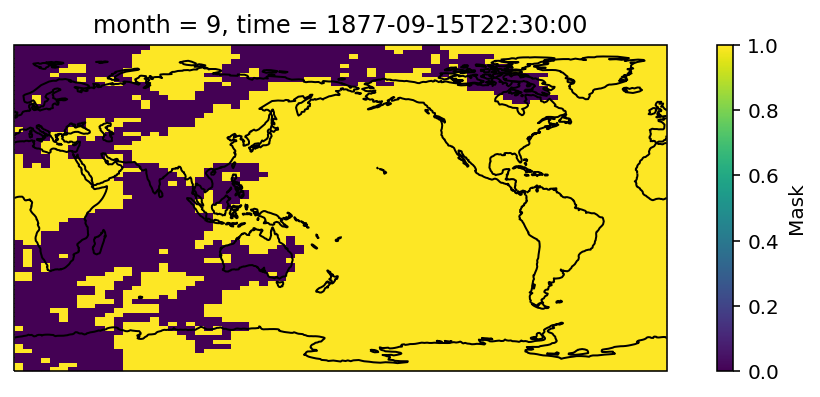

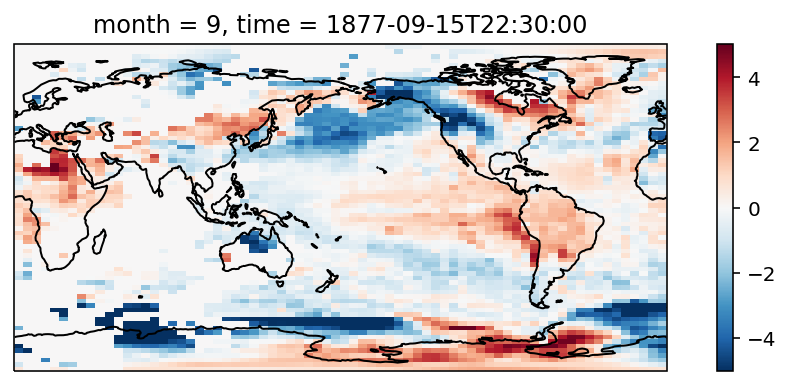

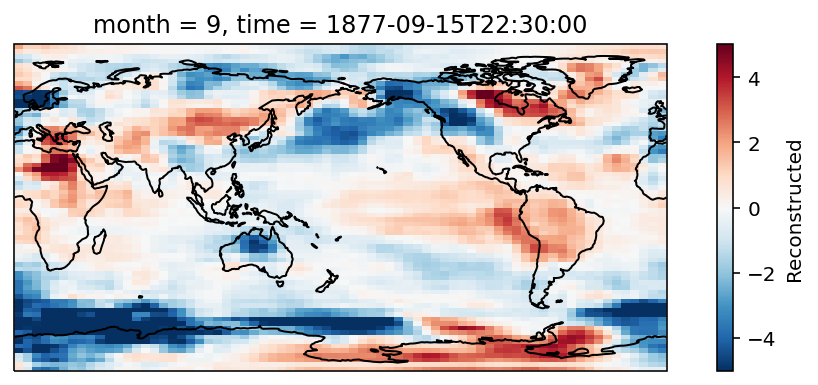

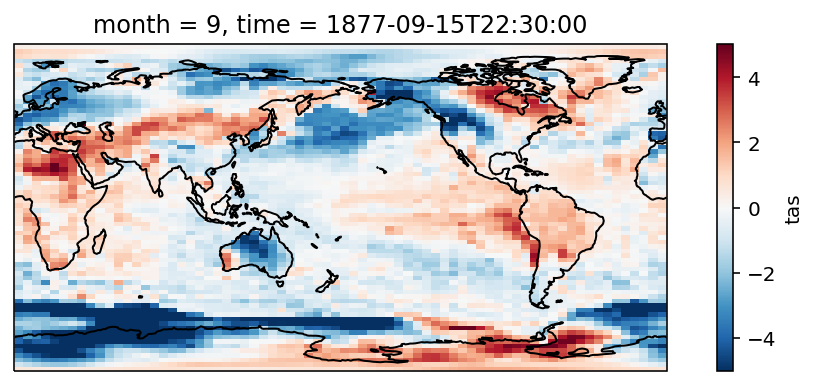

In [7]:
output = reconstruct_rwmasked(1)

### Reconstructing from masked points of medium length

The number of masked points is no more than 72\*72*5, a significant portion of the original image.
The model works moderately.

(72, 72)


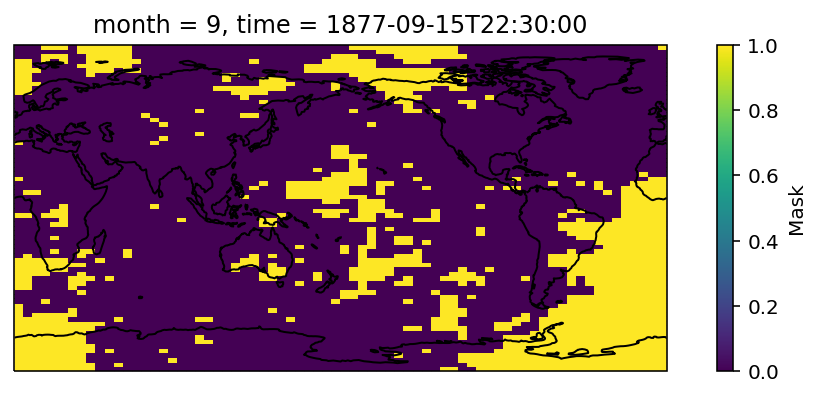

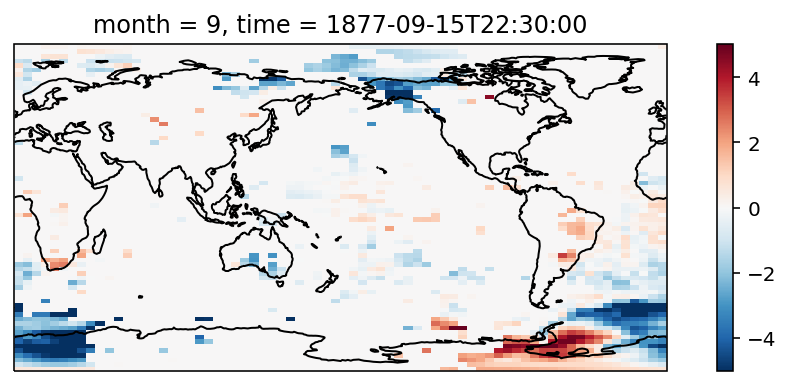

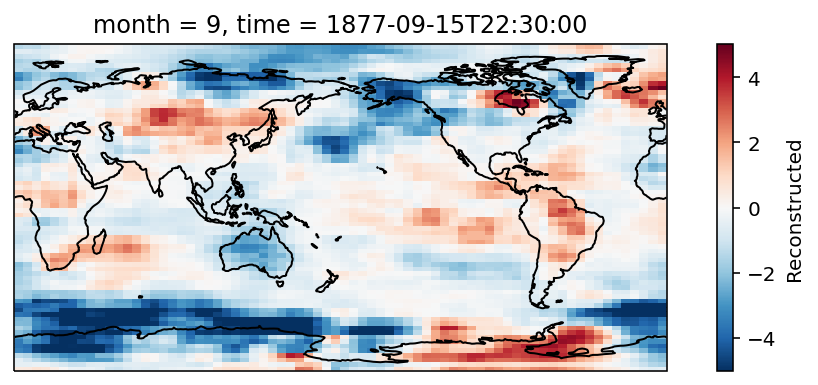

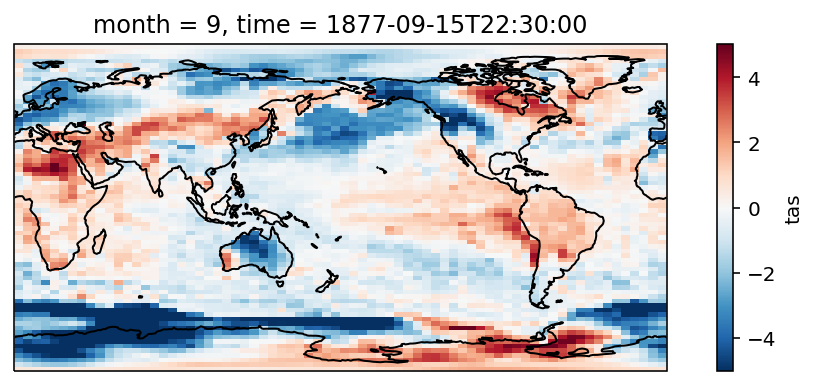

In [8]:
output = reconstruct_rwmasked(5)

### Reconstructing from masked points of large length

The number of masked points is no more than 72\*72*10, covering the most part of the entire image.
The model works bad.

(72, 72)


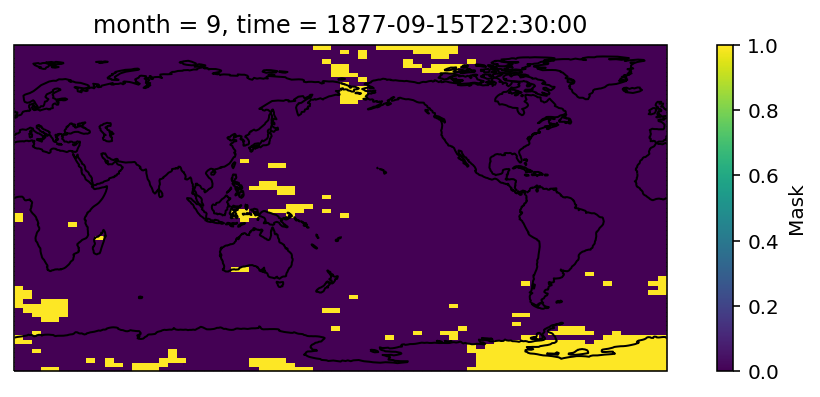

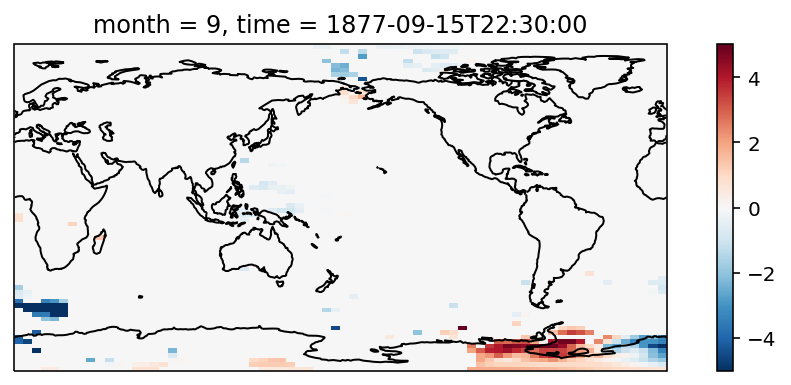

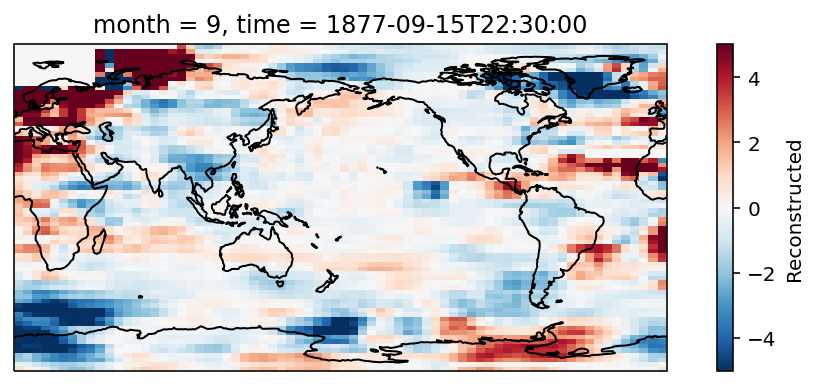

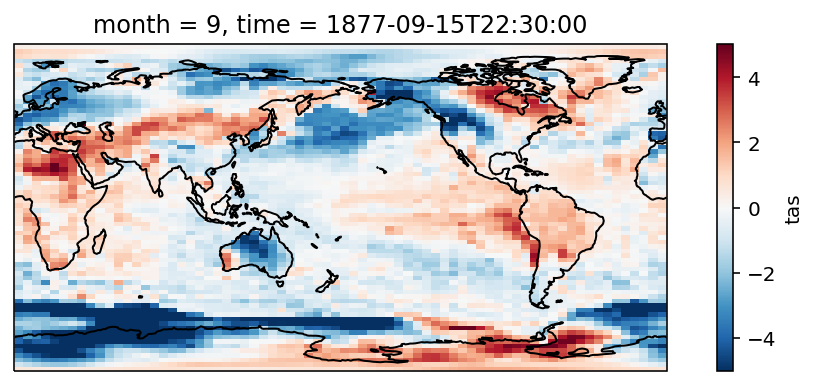

In [9]:
output = reconstruct_rwmasked(10)

In [10]:
# img = output[0, 0, :, :]
# scale = torch.max(img.max() - img.median(), img.median() - img.min())
# print(img.median(), scale, img.max(), img.min())
# img = (img - img.median() + scale) / scale * 0.5
# plt.imshow(img.numpy(), origin='lower')

## July 1877 of HadCRUT4 (Fig 3)

Length: 2
Data variables:
    temperature_anomaly  (time, latitude, longitude) float32 ...
    field_status         (time) |S1 ...


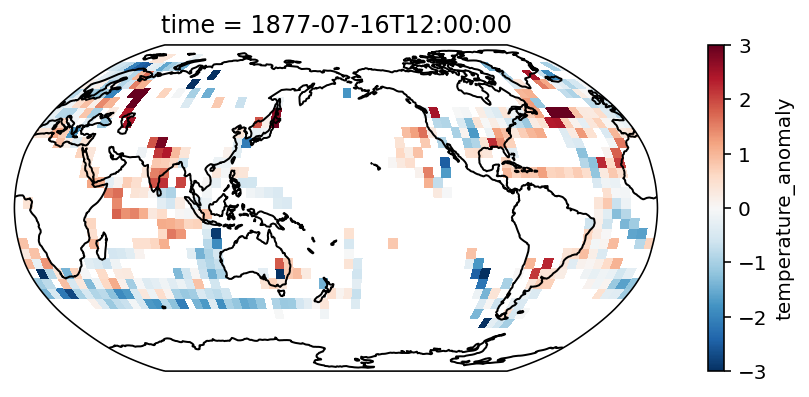

In [11]:
draw_dataset(dataset=dset_hc4, index=330, clip=3,
             central_longitude=180,
             proj='r',
             var='temperature_anomaly', x='longitude', y='latitude')

In [12]:
hc4_187707 = dset_hc4.temperature_anomaly[330]
hc4_187707_72x72 = hc4_187707.interp_like(
    xr.Dataset({
        'latitude': ('latitude', np.arange(-88.75, 90, 2.5)),
        'longitude': ('longitude', np.arange(-177.5, 180, 5)), }),
    method='nearest'
)

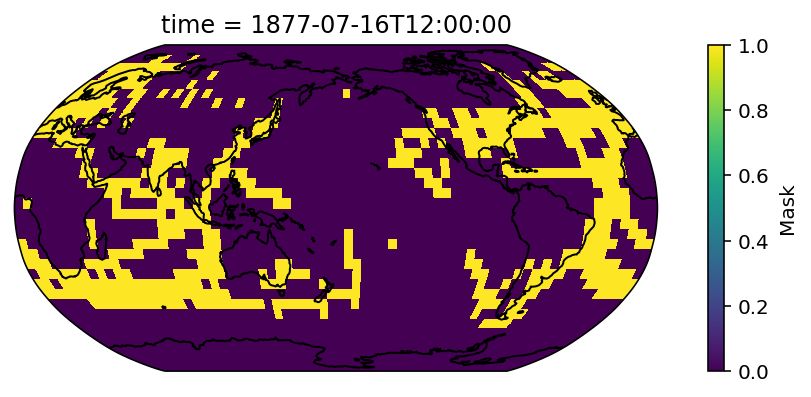

In [13]:
sample = hc4_187707_72x72.values
mask = np.ones((72, 72))
mask[np.isnan(sample)] = 0
mask_array = xr.DataArray(mask, name='Mask',
                          coords=hc4_187707_72x72.coords, dims=hc4_187707_72x72.dims)
draw_datapoint(mask_array,
               central_longitude=180,
               proj='r', x='longitude', y='latitude')

In [14]:
imagex3 = np.nan_to_num(sample).reshape((1, 1, 72, 72)) * np.ones((1, 3, 1, 1))
maskx3 = mask.reshape((1, 1, 72, 72)) * np.ones((1, 3, 1, 1))

imagex3 = torch.from_numpy(imagex3).float()
maskx3 = torch.from_numpy(maskx3).float()
with torch.no_grad():
    output, _ = model(imagex3 * maskx3, maskx3)

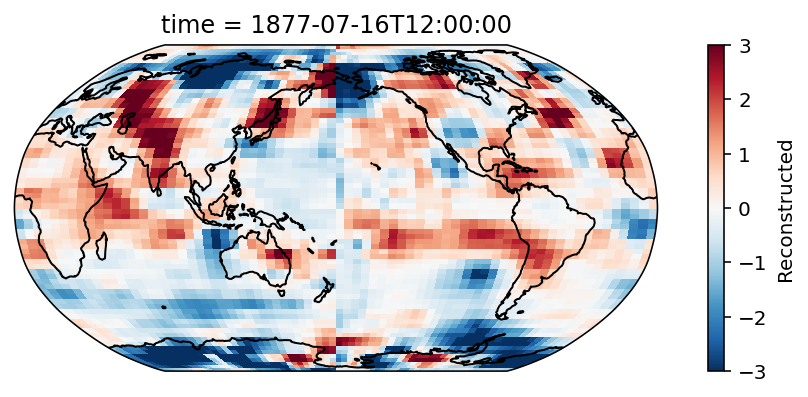

In [15]:
output_array = xr.DataArray(output.numpy()[0, 0, :, :].reshape(72, 72), name='Reconstructed',
                          coords=hc4_187707_72x72.coords, dims=hc4_187707_72x72.dims)
draw_datapoint(output_array, clip=3,
               central_longitude=180,
               proj='r', x='longitude', y='latitude')

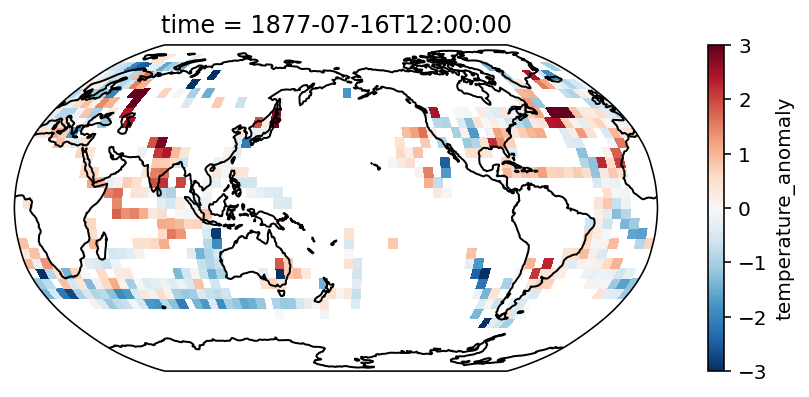

In [16]:
draw_datapoint(hc4_187707_72x72, clip=3,
               central_longitude=180,
               proj='r', x='longitude', y='latitude')

tensor(0.5000) tensor(7.0745) tensor(1.) tensor(0.0299)


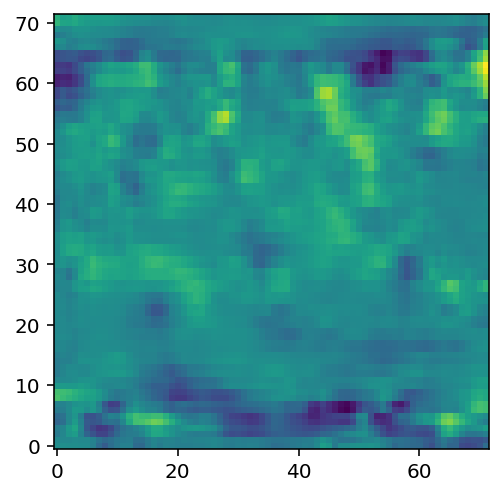

In [17]:
img = output[0, 0, :, :]
scale = torch.max(img.max() - img.median(), img.median() - img.min())
img = (img - img.median() + scale) / scale * 0.5
print(img.median(), scale, img.max(), img.min())
plt.imshow(img.numpy(), origin='lower')

## September 1877 of 20CR (Fig 1a - Fig 1d)

In [18]:
dset_20cr80 = xr.open_dataset('../dataset/data_large/20cr/20cr-mem080.h5')
tcr_187709 = dset_20cr80.tas[860]

In [19]:
# Extract the mask from Sep-1877 of HadCRUT4
hc4_187709 = dset_hc4.temperature_anomaly[332]
hc4_187709_72x72 = hc4_187709.interp_like(
    xr.Dataset({
        'latitude': ('latitude', np.arange(-88.75, 90, 2.5)),
        'longitude': ('longitude', np.arange(-177.5, 180, 5)), }),
    method='nearest'
)
sample = hc4_187709_72x72.values
mask = np.ones((72, 72))
mask[np.isnan(sample)] = 0
mask_array = xr.DataArray(mask, name='Mask',
                          coords=hc4_187709_72x72.coords, dims=hc4_187709_72x72.dims)


In [20]:
# The coordinate of mask array must be renamed and then translated by 180 degrees.
mask_array = mask_array.rename({'latitude': 'lat', 'longitude': 'lon'})
mask_array = mask_array.assign_coords({'lon': (mask_array.lon + 360) % 360})
mask_array = mask_array.interp_like(tcr_187709)

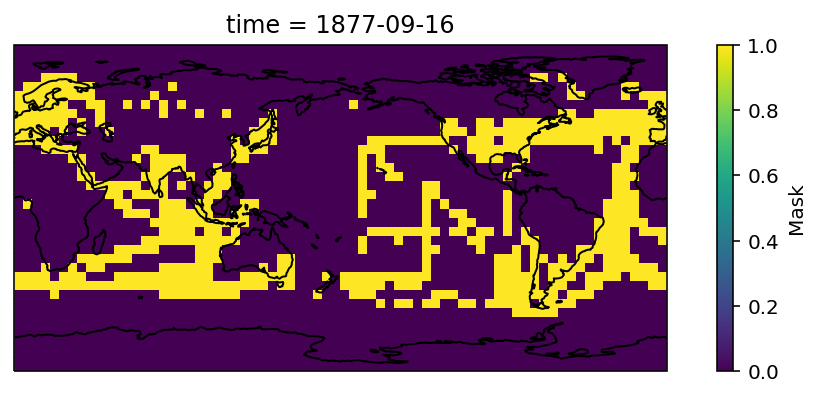

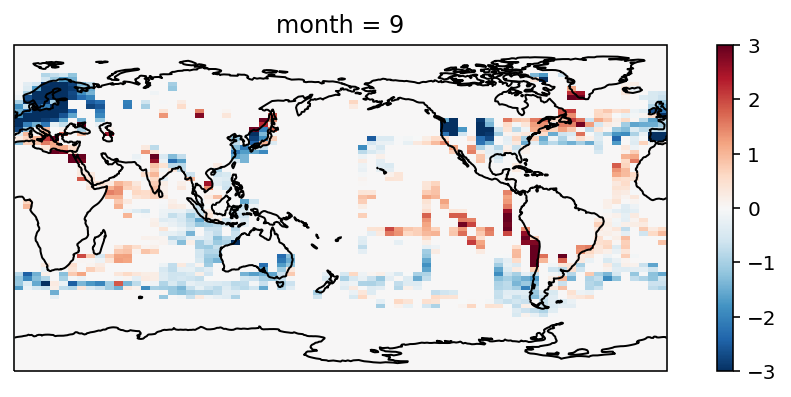

In [21]:
draw_datapoint(mask_array,
               central_longitude=180,
               proj='pc', x='lon', y='lat')
draw_datapoint(tcr_187709 * mask_array, clip=3,
               central_longitude=180,
               proj='pc', x='lon', y='lat')

In [22]:
imagex3 = tcr_187709.values.reshape((1, 1, 72, 72)) * np.ones((1, 3, 1, 1))
imagex3 = torch.from_numpy(imagex3).float()
with torch.no_grad():
    output, _ = model(imagex3 * maskx3, maskx3)

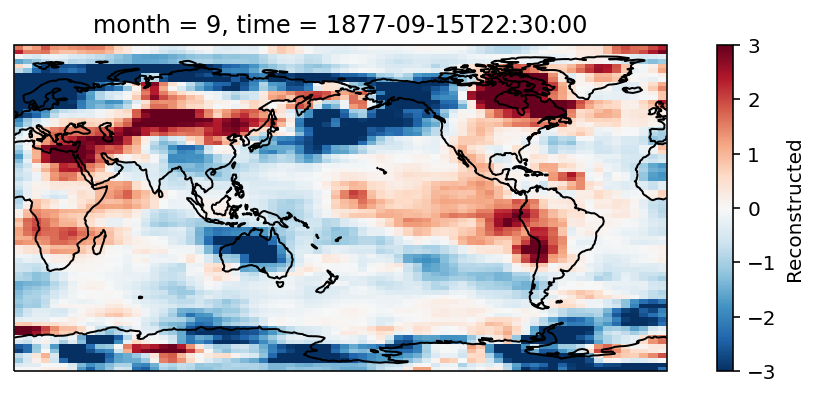

In [23]:
output_array = xr.DataArray(output.numpy()[0, 0, :, :].reshape(72, 72), name='Reconstructed',
                          coords=tcr_187709.coords, dims=tcr_187709.dims)
draw_datapoint(output_array, clip=3,
               central_longitude=180,
               proj='pc', x='lon', y='lat')

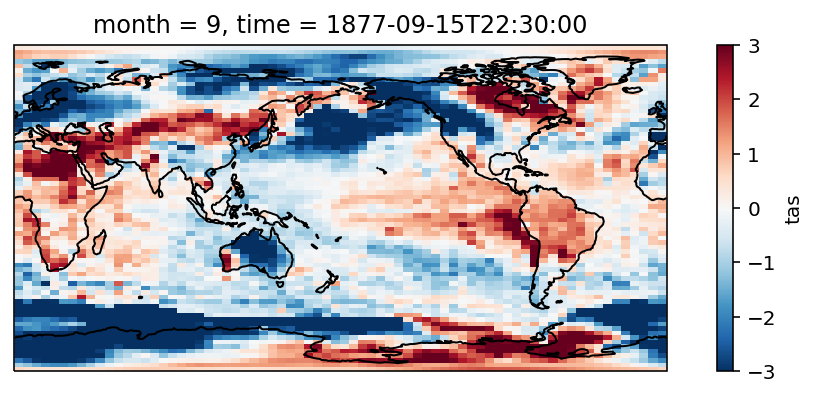

In [24]:
draw_datapoint(tcr_187709, clip=3,
               central_longitude=180,
               proj='pc', x='lon', y='lat')

torch.Size([72, 72])
tensor(0.5000) tensor(9.7016) tensor(0.7754) tensor(0.)


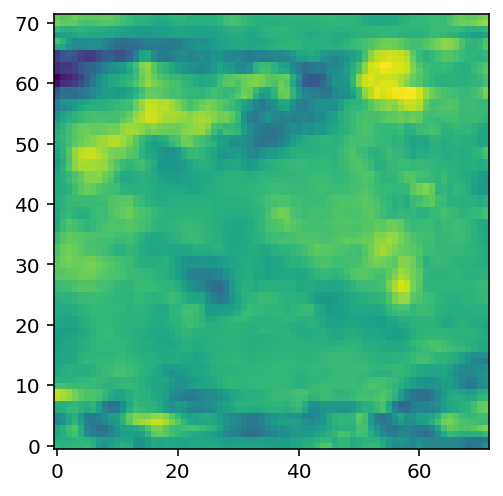

In [25]:
img = output[0, 2, :, :]
scale = torch.max(img.max() - img.median(), img.median() - img.min())
img = (img - img.median() + scale) / scale * 0.5
print(img.shape)
print(img.median(), scale, img.max(), img.min())
plt.imshow(img.numpy(), origin='lower')